mmpose install: \
`mmpose_install.ipynb` 파일 \
https://github.com/boostcampaitech3/final-project-level3-cv-13/blob/develop/mmpose_install.ipynb \
을 최상위 폴더에 넣고 실행

freihand dataset download: \
https://github.com/open-mmlab/mmpose/blob/master/docs/en/tasks/2d_hand_keypoint.md#freihand-dataset \
하란 대로 데이터 배치

train과 test에서 config는 \
`mmpose/configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py`를 사용함

train: \
`python tools/train.py configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py`

`ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 80 from PyObject` 에러가 뜰 경우 \
넘파이 업데이트 `pip install --upgrade numpy` 

test: \
이 `test.ipynb` 파일을 `mmpose/tools`에 넣고 실행

train 돌리지 않고 pretrained model 쓰고 싶으면 \
https://mmpose.readthedocs.io/en/latest/topics/hand%282d%29.html#freihand2d-dataset \
에서 `res50_freihand_224x224-ff0799bc_20200914.pth` 다운받아서 \
`mmpose/work_dirs/res50_freihand2d_224x224`에 넣어주고 \
아래 코드에서 `checkpoint_path` 부분 주석처리 해제

In [1]:
import argparse
import os
import os.path as osp
import warnings

import mmcv
import torch
from mmcv import Config, DictAction
from mmcv.cnn import fuse_conv_bn
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel
from mmcv.runner import get_dist_info, init_dist, load_checkpoint

from mmpose.apis import multi_gpu_test, single_gpu_test
from mmpose.datasets import build_dataloader, build_dataset
from mmpose.models import build_posenet
from mmpose.utils import setup_multi_processes

In [73]:
# cfg
cfg = Config.fromfile('../configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/mobilev3_freihand2d_224x224_cv7a.py')

# test.test_mode = True
cfg.model.pretrained = None
cfg.data.test.test_mode = True

# work_dir
cfg.work_dir = '../work_dirs'

# dataset = build_dataset

# test.py는 mmpose 디렉토리에서 python tools/test.py를 이용해 돌리지만
# 이 test.ipynb 파일은 mmpose/tools 디렉토리에서 돌리기 때문
cfg.data.test.ann_file = '../data/cv7ahand/annotations/cv7ahand_test.json'
cfg.data.test.img_prefix = '../data/cv7ahand/'
# cfg.data.test

dataset = build_dataset(cfg.data.test, dict(test_mode=True))
# dataset
# next(iter(dataset))

"""
# 그냥 궁금해서 train dataset 구조 확인
cfg.data.train.ann_file = '../data/freihand/annotations/freihand_train.json'
cfg.data.train.img_prefix = '../data/freihand/'
dataset = build_dataset(cfg.data.train)
# dataset
next(iter(dataset))
"""

# 'distributed=True' means multi gpu setup
data_loader = build_dataloader(dataset, samples_per_gpu=1, workers_per_gpu=1, dist=False, shuffle=False)

model = build_posenet(cfg.model)

checkpoint_path = '../work_dirs/mobilev3_freihand2d_224x224_cv7a/best_AUC_epoch_75_220605_C.pth'

load_checkpoint(model, checkpoint_path, map_location='cpu')

model = MMDataParallel(model.cuda(), device_ids=[0])
outputs = single_gpu_test(model, data_loader)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
=> num_images: 423
=> load 423 samples
load checkpoint from local path: ../work_dirs/mobilev3_freihand2d_224x224_cv7a/best_AUC_epoch_75_220605_C.pth
[                                ] 7/423, 27.5 task/s, elapsed: 0s, ETA:    15s

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 423/423, 42.5 task/s, elapsed: 10s, ETA:     0s

In [74]:
outputs[0]

{'preds': array([[[109.600006  , 149.6       ,   0.7870312 ],
         [127.20001   , 148.        ,   0.9063601 ],
         [144.8       , 135.20001   ,   0.9606246 ],
         [154.40001   , 120.8       ,   0.92322123],
         [164.        , 109.600006  ,   0.90551597],
         [143.20001   , 116.        ,   0.897793  ],
         [152.8       ,  98.399994  ,   0.91192687],
         [157.6       ,  85.600006  ,   1.0173709 ],
         [162.40001   ,  77.600006  ,   0.93120766],
         [130.4       , 112.8       ,   0.93187356],
         [130.4       , 101.600006  ,   0.9139504 ],
         [124.        , 116.        ,   0.8658114 ],
         [124.        , 124.        ,   0.9060326 ],
         [119.20001   , 112.8       ,   0.92067635],
         [114.399994  , 104.8       ,   0.93362224],
         [112.8       , 117.600006  ,   0.89186084],
         [114.399994  , 124.        ,   0.9375874 ],
         [106.399994  , 114.399994  ,   0.8694211 ],
         [103.20001   , 106.399994  ,

258


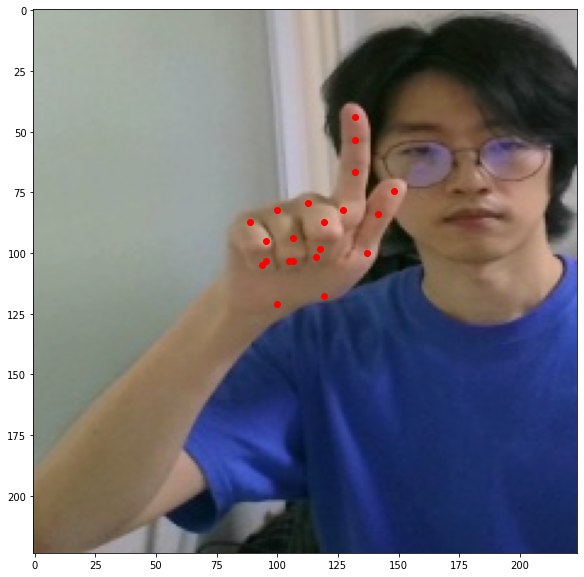

In [233]:
import matplotlib.pyplot as plt
# import cv2
import matplotlib as mpl
import numpy as np
import os

i = np.random.randint(0, len(outputs))
print(i)

output = outputs[i]
img_path = output['image_paths'][0]

# img = cv2.imread(img_path)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = mpl.image.imread(img_path)

fig, ax = plt.subplots(figsize=(10,10))

kp = []
for hand in output['preds']:
    l = []
    for keypoint in hand:
        x = keypoint[0]
        y = keypoint[1]
        l.append((x, y))
    kp.append(l)
        
for hand in kp:
    for keypoint in hand:
        ax.scatter(keypoint[0], keypoint[1], color='red')

plt.imshow(img)
plt.show()